### Stratégie de Généralisation de Domaine (DG)

**Objectif :** Évaluer la capacité de random forest à prédire les classes de prix sur des villes non vues lors de l'entraînement.

#### 1. Construction du Dataset Multi-Domaine
* **Villes Sources (Train) :** Paris + Rome + Madrid 
* **Ville Cible (Test) :** Vienne
* **Justification :** L'inclusion de domaines variés réduit le biais spécifique à une ville et favorise l'extraction de features universelles.

#### 2. Alignement des Distributions
Les features continues (distance, scores) sont centrées-réduites par rapport à la moyenne/écart-type de *leur propre ville*.
Les classes Q1-Q4 sont définies sur la distribution des prix de chaque ville de manière isolée.

#### 3. Évaluation
* Comparaison de l'accuracy entre le test intra-ville (Test sur Paris) et le test inter-ville (Test sur Vienne).
* Analyse de l'importance des features : Les variables importantes restent-elles les mêmes d'un pays à l'autre ?

Pas obligatoire a re executer, le df est déja construit et prêt à l'emploi.

In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.utils import resample
from sklearn.model_selection import GridSearchCV

In [2]:
processed_files = {
    "paris": "data/paris_dataset_final_ready.csv.gz",
    "rome": "data/rome_dataset_final_ready.csv.gz",
    "madrid": "data/madrid_dataset_final_ready.csv.gz"
}

# 1. Chargement et concaténation directe
li = []
for city, path in processed_files.items():
    df = pd.read_csv(path, compression='gzip')
    li.append(df)

df_train_global = pd.concat(li, axis=0, ignore_index=True)

print(f" Dataset Global Fusionné : {df_train_global.shape}")
print(f" Répartition par ville :\n{df_train_global['city_label'].value_counts()}")

# 2. Sauvegarde pour les notebooks de modélisation
df_train_global.to_csv("data/train_multi_city_global.csv.gz", index=False, compression='gzip')

 Dataset Global Fusionné : (125628, 30)
 Répartition par ville :
city_label
Paris     73111
Rome      33564
Madrid    18953
Name: count, dtype: int64


modele random forest sur les données de Paris, Rome et Madrid, puis test sur Vienne.

On fait une stratification croisée sur la ville et la quantiles des prix pour s'assurer que les classes sont équilibrées dans les splits. Cett stratification sert a réduire le volume du dataset pour la grid search

In [3]:
stratify_key = df_train_global['city_label'].astype(str) + "_" + df_train_global['target_class'].astype(str)

print("Distribution des 12 sous-groupes avant échantillonnage :")
print(stratify_key.value_counts(normalize=True).head())

Distribution des 12 sous-groupes avant échantillonnage :
Paris_0    0.152148
Paris_2    0.145660
Paris_3    0.145262
Paris_1    0.138894
Rome_1     0.067907
Name: proportion, dtype: float64


In [4]:
df_search, _ = train_test_split(
    df_train_global, 
    train_size=0.25,     # On garde 25% pour le Grid Search (environ 30k)
    stratify=stratify_key,   
    random_state=123
)

In [5]:
# Séparation X (features) et y (target)
y_search = df_search['target_class']
X_search = df_search.drop(columns=['target_class', 'price_clean', 'city_label'])  
# On retire aussi 'price_clean' qui est une métadonnée

print(f"\nFeatures (X) : {X_search.shape[1]} colonnes")
print(f"Target (y) : {len(y_search)} valeurs")
print(f"\nDistribution des classes :")
print(y_search.value_counts().sort_index())

# Pour l'entrainement final
X_train_full = df_train_global.drop(columns=['target_class', 'price_clean', 'city_label'])
y_train_full = df_train_global['target_class']

print(f"Shape de X_search (Grid Search) : {X_search.shape}")
print(f" Shape de X_train_full (Final) : {X_train_full.shape}")


Features (X) : 27 colonnes
Target (y) : 31407 valeurs

Distribution des classes :
target_class
0    8077
1    7682
2    7820
3    7828
Name: count, dtype: int64
Shape de X_search (Grid Search) : (31407, 27)
 Shape de X_train_full (Final) : (125628, 27)


In [6]:
# Vérification scientifique que la stratification a fonctionné :
print("Vérification de la distribution de Paris_0 :")
prop_full = (stratify_key == "Paris_0").mean()
prop_search = ((df_search['city_label'] == 'Paris') & (df_search['target_class'] == 0)).mean()
print(f"   Dans les 125k lignes : {prop_full*100:.2f}%")
print(f"   Dans les 25k lignes  : {prop_search*100:.2f}%")

Vérification de la distribution de Paris_0 :
   Dans les 125k lignes : 15.21%
   Dans les 25k lignes  : 15.21%


Grid search pour trouver les meilleurs hyperparamètres avec validation croisée

In [7]:
param_grid = {
# Plus profond car la donnée est multi-culturelle que pour le cas paris seul

    'max_depth': [15, 20, 25, None],

    # On force les feuilles à contenir plus de monde. Si une feuille doit 
    # contenir 10 annonces, elle a plus de chance de regrouper des annonces 
    # de plusieurs villes, forçant l'algorithme à trouver des invariants.
    'min_samples_leaf': [2, 5, 10],
    
    # Combien d'exemples faut-il au minimum pour avoir le droit de diviser un nœud ?
    'min_samples_split': [5, 10, 20],

    
    'n_estimators': [200, 300],

    # On s'en tient à ça pour limiter le temps de calcul.
    'max_features': ['sqrt']
}

In [8]:
print(y_search.value_counts(normalize=True))

target_class
0    0.257172
3    0.249244
2    0.248989
1    0.244595
Name: proportion, dtype: float64


In [9]:
def run_domain_generalization_grid_search(X, y, param_grid, cv_folds=3, scoring_metric='f1_macro'):
    print(f" Lancement de la Grid Search Multi-Domaines (Métrique : {scoring_metric}, CV : {cv_folds})...")
    
    # Ajout de class_weight='balanced' pour la robustesse inter-classes
    rf = RandomForestClassifier(random_state=42, n_jobs=-1)
    
    grid_search = GridSearchCV(
        estimator=rf,
        param_grid=param_grid,
        cv=cv_folds,             # 3-Fold Cross Validation
        scoring=scoring_metric,
        return_train_score=True, 
        n_jobs=-1,
        verbose=1
    )
    
    # Entraînement sur le sous-échantillon équilibré (X_search)
    grid_search.fit(X, y)
    
    results = pd.DataFrame(grid_search.cv_results_)
    
    # Extraction des hyperparamètres spécifiques à notre nouvelle grille
    cols_interest = [
        'param_max_depth', 
        'param_max_features', 
        'param_min_samples_leaf', 
        'param_min_samples_split', 
        'param_n_estimators',
        'mean_test_score',        
        'std_test_score',          # Variance inter-folds
        'mean_train_score'         
    ]
    summary = results[cols_interest].copy()
    
    summary.rename(columns={
        'mean_test_score': 'Score_Moyen_CV',
        'std_test_score': 'Ecart_Type_CV (Variance)',
        'mean_train_score': 'Score_Train (Overfit?)'
    }, inplace=True)
    
    summary = summary.sort_values(by='Score_Moyen_CV', ascending=False)
    
    return grid_search.best_estimator_, summary

In [10]:
best_model_dg, res_dg = run_domain_generalization_grid_search(
    X_search, 
    y_search, 
    param_grid=param_grid, 
    cv_folds=3, 
    scoring_metric='f1_macro'
)

print(" TOP 5 CONFIGURATIONS (GÉNÉRALISATION DE DOMAINE - F1-MACRO) :")
print(res_dg.head(5).to_string(index=False))

 Lancement de la Grid Search Multi-Domaines (Métrique : f1_macro, CV : 3)...
Fitting 3 folds for each of 72 candidates, totalling 216 fits
 TOP 5 CONFIGURATIONS (GÉNÉRALISATION DE DOMAINE - F1-MACRO) :
param_max_depth param_max_features  param_min_samples_leaf  param_min_samples_split  param_n_estimators  Score_Moyen_CV  Ecart_Type_CV (Variance)  Score_Train (Overfit?)
             25               sqrt                       2                       10                 200        0.546220                  0.001192                0.865382
             25               sqrt                       2                        5                 200        0.545987                  0.003983                0.941918
             25               sqrt                       2                        5                 300        0.545893                  0.003926                0.942493
           None               sqrt                       2                       10                 300        0.54570

In [22]:
# optimal parameters hardcoded for final training
best_params_dg = {
    'max_depth': 25,
    'max_features': 'sqrt',
    'min_samples_leaf': 2,
    'min_samples_split': 10,
    'n_estimators': 100
}


🌲 Initialisation du Random Forest Global (Titan)...
⚖️ Calcul des poids de pondération pour l'invariance de domaine...
🚀 Lancement de l'entraînement sur la matrice complète (125628, 27)...
   (Cela peut prendre quelques minutes vu le volume de données)

✅ Modèle Global entraîné avec succès !
🌍 Score OOB (Out-Of-Bag) : 0.5747

📊 Extraction des variables les plus importantes (Top 10)...
               Feature  Importance
        dist_to_center    0.161092
      neigh_popularity    0.105623
     number_of_reviews    0.089177
          accommodates    0.086357
minimum_nights_avg_ntm    0.083468
              bedrooms    0.073821
         bathrooms_qty    0.048594
                  beds    0.040364
    score_chef_kitchen    0.039493
          score_coffee    0.027521


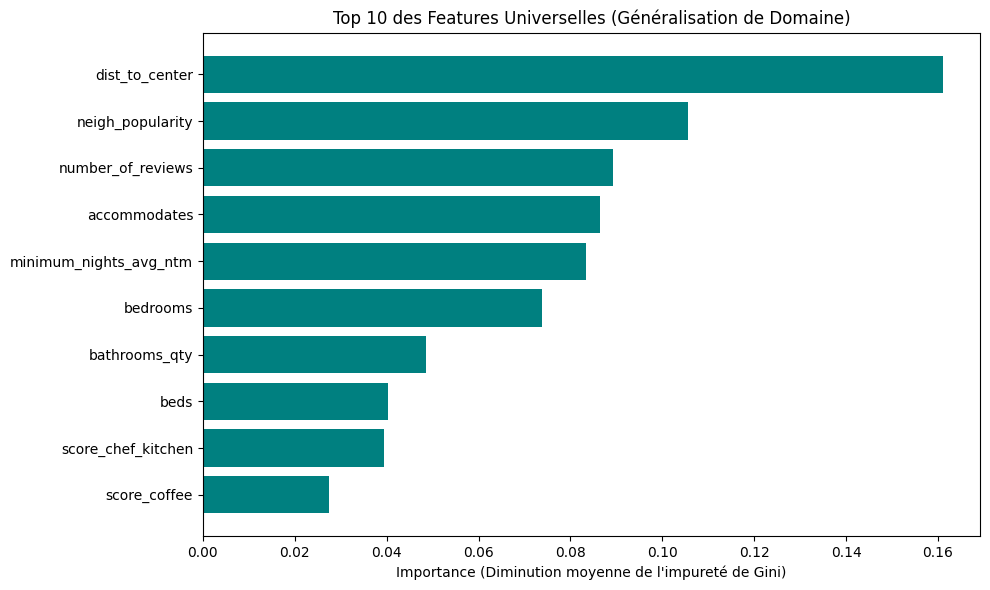

In [ ]:
from sklearn.utils.class_weight import compute_sample_weight

# =====================================================================
# 1. INSTANCIATION DU MODÈLE FINAL (Avec les meilleurs hyperparamètres)
# =====================================================================
print("🌲 Initialisation du Random Forest Global (Titan)...")

# On utilise explicitement les paramètres du Modèle N°1 validés précédemment
final_rf = RandomForestClassifier(
    max_depth=25,
    max_features='sqrt',
    min_samples_leaf=2,
    min_samples_split=10,
    n_estimators=200,
    oob_score=True,       # Crucial : permet d'évaluer la généralisation sans set de validation
    random_state=42,
    n_jobs=-1
)

# =====================================================================
# 2. CALCUL DES POIDS DE DOMAINE (DOMAIN WEIGHTING)
# =====================================================================
print("⚖️ Calcul des poids de pondération pour l'invariance de domaine...")

# L'objectif est que Paris (75k lignes) ne dicte pas sa loi à Rome/Madrid (25k lignes).
# compute_sample_weight attribue un multiplicateur mathématique à chaque ligne.
domain_weights = compute_sample_weight(
    class_weight='balanced', 
    y=df_train_global['city_label'] 
)

# =====================================================================
# 3. ENTRAÎNEMENT DU MODÈLE
# =====================================================================
print(f"🚀 Lancement de l'entraînement sur la matrice complète {X_train_full.shape}...")
print("   (Cela peut prendre quelques minutes vu le volume de données)")

final_rf.fit(X_train_full, y_train_full, sample_weight=domain_weights)

print(f"\n✅ Modèle Global entraîné avec succès !")
print(f"🌍 Score OOB (Out-Of-Bag) : {final_rf.oob_score_:.4f}")

# =====================================================================
# 4. INTERPRÉTABILITÉ : IMPORTANCE DES FEATURES (INVARIANCES)
# =====================================================================
print("\n📊 Extraction des variables les plus importantes (Top 10)...")

# Création d'un DataFrame pour visualiser le poids de chaque feature
feature_importances = pd.DataFrame({
    'Feature': X_train_full.columns,
    'Importance': final_rf.feature_importances_
}).sort_values(by='Importance', ascending=False)

# Affichage console
print(feature_importances.head(10).to_string(index=False))

# Visualisation Graphique (Parfait pour votre rapport/soutenance)
plt.figure(figsize=(10, 6))
plt.barh(feature_importances['Feature'][:10][::-1], feature_importances['Importance'][:10][::-1], color='teal')
plt.title("Top 10 des Features Universelles (Généralisation de Domaine)")
plt.xlabel("Importance (Diminution moyenne de l'impureté de Gini)")
plt.tight_layout()
plt.show()

In [14]:
def rerank_predictions(y_proba):
    """
    Prend les probabilités (N, 4) d'un modèle et force une distribution 
    parfaite en 4 quartiles (25% chacun) basée sur l'espérance mathématique.
    """
    # 1. Calcul de l'espérance de la classe (score continu de 0 à 3)
    classes = np.array([0, 1, 2, 3])
    expected_scores = np.dot(y_proba, classes)
    
    # 2. Classement de tous les appartements (rank)
    # 'first' permet de départager les égalités parfaites
    ranks = pd.Series(expected_scores).rank(method='first')
    
    # 3. Découpage en 4 quartiles stricts (Le Reranking)
    y_pred_reranked = pd.qcut(ranks, q=4, labels=[0, 1, 2, 3]).astype(int)
    
    return y_pred_reranked.values

In [20]:
# testing on test set
from sklearn.metrics import f1_score



df_vienna = pd.read_csv("data/vienna_dataset_final_ready.csv.gz", compression='gzip')
X_test, y_test = df_vienna.drop(columns=['target_class', 'price_clean', 'city_label']), df_vienna['target_class']

# 1. Prédiction classique (Brute)
y_pred_brut = final_rf.predict(X_test)

# 2. Prédiction Probabiliste
y_proba_vienna = final_rf.predict_proba(X_test)

# 3. Reranking !
y_pred_reranked = rerank_predictions(y_proba_vienna)

# 4. Comparaison
print("📊 AVANT Reranking (F1-Macro) :", f1_score(y_test, y_pred_brut, average='macro'))
print("🚀 APRÈS Reranking (F1-Macro) :", f1_score(y_test, y_pred_reranked, average='macro'))

print("\nNouveau Classification Report (Après Reranking) :")
print(classification_report(y_test, y_pred_reranked))

📊 AVANT Reranking (F1-Macro) : 0.42654187535006516
🚀 APRÈS Reranking (F1-Macro) : 0.47123709563438276

Nouveau Classification Report (Après Reranking) :
              precision    recall  f1-score   support

           0       0.58      0.56      0.57      2662
           1       0.34      0.34      0.34      2562
           2       0.36      0.37      0.36      2513
           3       0.61      0.61      0.61      2569

    accuracy                           0.47     10306
   macro avg       0.47      0.47      0.47     10306
weighted avg       0.47      0.47      0.47     10306



Leave one city out : on entraine sur 3 villes et on teste sur la 4ème pour évaluer la généralisation de domaine.

In [24]:
def run_ultimate_lodo_cv(df_all_cities, best_params):
    print("🌍 Lancement de la Validation Croisée LODO (Avec Reranking Intégré)...")
    print("-" * 70)
    
    cities = df_all_cities['city_label'].unique()
    results = []
    
    for test_city in cities:
        print(f"\n🔄 ITÉRATION : Entraînement sur les autres capitales -> Test sur {test_city.upper()}")
        
        # --- A. Séparation Train / Test par Domaine ---
        df_train = df_all_cities[df_all_cities['city_label'] != test_city]
        df_test  = df_all_cities[df_all_cities['city_label'] == test_city]
        
        X_train = df_train.drop(columns=['target_class', 'price_clean', 'city_label'])
        y_train = df_train['target_class']
        
        X_test = df_test.drop(columns=['target_class', 'price_clean', 'city_label'])
        y_test = df_test['target_class']
        
        # --- B. Invariance de Domaine (Domain Weighting) ---
        print(f"   [Train] {len(df_train)} annonces. Équilibrage du poids des villes...")
        domain_weights = compute_sample_weight(
            class_weight='balanced', 
            y=df_train['city_label'] # Pondération par la VILLE
        )
        
        # --- C. Entraînement du Modèle Titan ---
        rf = RandomForestClassifier(
            **best_params, 
            random_state=42, 
            n_jobs=-1,
            class_weight='balanced' # Filet de sécurité intra-classe
        )
        rf.fit(X_train, y_train, sample_weight=domain_weights)
        
        # --- D. Prédiction et Reranking sur le Domaine Inconnu ---
        print(f"   [Test] Évaluation sur {len(df_test)} annonces de {test_city.capitalize()}...")
        y_proba = rf.predict_proba(X_test)
        y_pred_final = rerank_predictions(y_proba)
        
        # --- E. Calcul des Métriques ---
        f1_mac = f1_score(y_test, y_pred_final, average='macro')
        acc = accuracy_score(y_test, y_pred_final)
        
        print(f"   🎯 {test_city.capitalize()} (Reranked) -> F1-macro: {f1_mac:.4f} | Accuracy: {acc:.4f}")
        
        results.append({
            'Ville_Cible (Test)': test_city.capitalize(),
            'Villes_Sources (Train)': ", ".join([c.capitalize() for c in cities if c != test_city]),
            'F1_Macro': f1_mac,
            'Accuracy': acc
        })
        
    # --- F. Synthèse Globale ---
    print("\n" + "=" * 70)
    print("🏁 BILAN SCIENTIFIQUE DU LODO-CV")
    print("=" * 70)
    
    df_results = pd.DataFrame(results)
    
    # Calcul de la moyenne pour évaluer la robustesse globale
    mean_f1 = df_results['F1_Macro'].mean()
    mean_acc = df_results['Accuracy'].mean()
    
    # Ajout d'une ligne "Moyenne" propre
    df_results.loc['Moyenne Globale'] = ["-", "-", mean_f1, mean_acc]
    
    return df_results

In [25]:
df_paris = pd.read_csv("data/paris_dataset_final_ready.csv.gz", compression='gzip')
df_rome = pd.read_csv("data/rome_dataset_final_ready.csv.gz", compression='gzip')
df_madrid = pd.read_csv("data/madrid_dataset_final_ready.csv.gz", compression='gzip')

df_all_cities = pd.concat([df_paris, df_rome, df_madrid, df_vienna], ignore_index=True)

tableau_final_lodo = run_ultimate_lodo_cv(df_all_cities, best_params_dg)
display(tableau_final_lodo)

🌍 Lancement de la Validation Croisée LODO (Avec Reranking Intégré)...
----------------------------------------------------------------------

🔄 ITÉRATION : Entraînement sur les autres capitales -> Test sur PARIS
   [Train] 62823 annonces. Équilibrage du poids des villes...
   [Test] Évaluation sur 73111 annonces de Paris...
   🎯 Paris (Reranked) -> F1-macro: 0.4555 | Accuracy: 0.4568

🔄 ITÉRATION : Entraînement sur les autres capitales -> Test sur ROME
   [Train] 102370 annonces. Équilibrage du poids des villes...
   [Test] Évaluation sur 33564 annonces de Rome...
   🎯 Rome (Reranked) -> F1-macro: 0.4357 | Accuracy: 0.4357

🔄 ITÉRATION : Entraînement sur les autres capitales -> Test sur MADRID
   [Train] 116981 annonces. Équilibrage du poids des villes...
   [Test] Évaluation sur 18953 annonces de Madrid...
   🎯 Madrid (Reranked) -> F1-macro: 0.5173 | Accuracy: 0.5173

🔄 ITÉRATION : Entraînement sur les autres capitales -> Test sur VIENNA
   [Train] 125628 annonces. Équilibrage du poid

,Ville_Cible (Test),Villes_Sources (Train),F1_Macro,Accuracy
0,Paris,"Rome, Madrid, Vienna",0.455503,0.456812
1,Rome,"Paris, Madrid, Vienna",0.435658,0.435735
2,Madrid,"Paris, Rome, Vienna",0.517323,0.517280
3,Vienna,"Paris, Rome, Madrid",0.469484,0.470309
Moyenne Globale,-,-,0.469492,0.470034
